## 1. Generate the source dataframes

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
(200, 3)


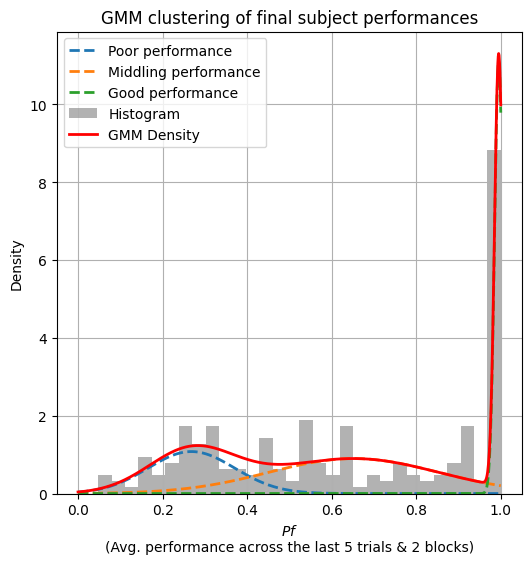

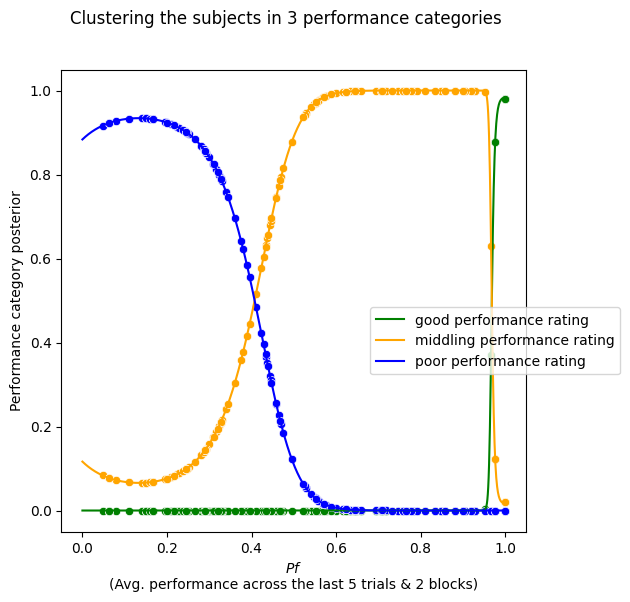

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\analysis_tools\dataframe_from_raw_data.py:351: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


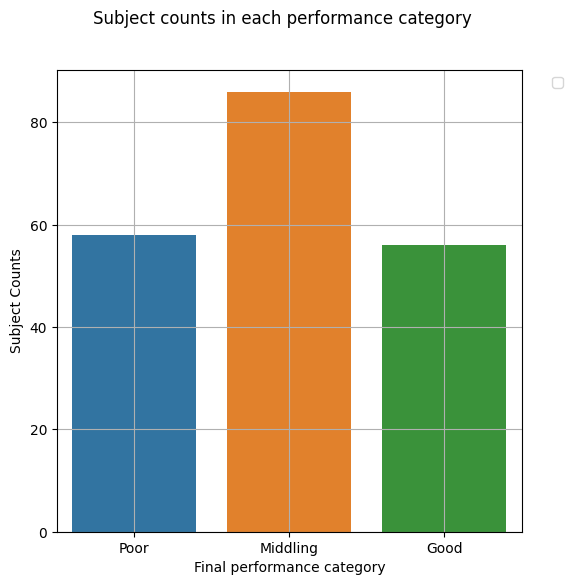

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\results\cluster_inversions\logs


In [1]:
import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from functools import partial
import importlib   # To import model files with poorly written names  ¯\_(ツ)_/¯
from tabulate import tabulate # to make pretty tables : 

from sklearn.mixture import GaussianMixture

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd
# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
from analysis_tools.dataframe_from_raw_data import get_full_dataframe_from_raw_data

# The simulated environment :
from simulate.generate_observations_full_actions import TrainingEnvironment,simulate_training
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import generate_synthetic_data

# The inversion scripts :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from simulate.invert_model import invert_data_for_single_model,invert_data_for_library_of_models,invert_data_for_single_model_cluster
from simulate.simulate_utils import ind2sub,discretize_normal_pdf

from simulate.plot_trajectory import plot_actions,plot_learnt_transition_matrix,plot_learnt_q_table

# The agent class : 
from simulate.general_agent import Agent

LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    # "study_1" : {
    #     "dict_code" : "002",
    #     "internal_task_id" : "002",
    #     "studies_id" : None,
    #     "exclude_subjects" : ["5c9cb670b472d0001295f377"],
    #     "feedback_noise_bins" : [0,0.2,0.4,1]
    # },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}

LAST_T_TIMESTEPS = 5
LAST_K_TRIALS = 2
subjects_df = get_full_dataframe_from_raw_data(STUDIES_EXTRACTION_CODES,LLM_CLASSIFS_PATH,LAST_T_TIMESTEPS,LAST_K_TRIALS)


EXECUTOR_LOGPATH = os.path.join("results","cluster_inversions","logs")
RESULTS_SAVEPATH = os.path.join("results","cluster_inversions","inversion_mle_no_selector")
if not os.path.exists(RESULTS_SAVEPATH):
    os.makedirs(RESULTS_SAVEPATH)
print(os.path.join(os.getcwd(),EXECUTOR_LOGPATH))


n_jours_max = 7
JOB_MAXTIME = 60*24*n_jours_max
JOB_CPUS = 8
JOB_PARTITION = 'CPU'
JOB_NODES = 1
JOB_MAX_ARRAY = 30
JOB_NAME_FUNC = (lambda x : "BRUH_{}".format(x))
method = 'mle'

## 2. Preprocess the data 

In [2]:
inverted_dataframe = subjects_df[(subjects_df["study_name"]=="study_2")|(subjects_df["study_name"]=="study_3")]
# environment constants :
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD =   0.175#0.025#0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(a,b,c,d,e,u,T,NTRIALS)



# define the static dimensions of the problem :
No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES
MODEL_CONSTANTS = {
    "position" : {
        "Th" : 2,
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "angle" : {
        "Th" : 2,
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "Th" : 2,
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
}


# If the points were too close, no angle was recorded :
# The limit was arbitrarily chosen at 7.5 units :
min_dist_norm = 7.5/(np.sqrt(2)*750)

preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : N_FEEDBACK_OUTCOMES,
        "observation_ends_at_point" : 2
    }
}
# We can modify these at will


# The preprocessing here assumes two possible observations : 
# - the mean of the gauge level between subject actions (index 0) 
# - the last value before subject action (index 1).
inverted_data_all = get_preprocessed_data_from_df(inverted_dataframe,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default",
                            filter_angles_if_small_distance = True)


formatted_stimuli= [inverted_data_all["observations"]["vect"][1]]
bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
rewards = jnp.array(inverted_data_all["observations"]["deltas"])

actions = {}
for action_dim in ["position","distance","angle"]:
    actions[action_dim] = jnp.array(inverted_data_all["actions"]["vect"][action_dim])[:,:-1,:,:] # Ignore the last trial

Nsubj,Ntrials,Nactions,_ = actions[action_dim].shape
timesteps = jnp.broadcast_to(jnp.arange(Nactions+1),(Nsubj,Ntrials,Nactions+1))

inverted_data = (formatted_stimuli,bool_stimuli,rewards,actions,timesteps)



formatted_stimuli,_,_,_,_ = inverted_data
Nsubj,Ntrials,Ntimesteps,_ = formatted_stimuli[0].shape

Out of the 22000.0 actions performed by our subjects, 21953.0 were 'valid' (99.8 %)
Out of the 22000.0 feedback sequences potentially observed by our subjects, 22000 were 'valid' (100.0 %)


## 3. Model space

Here, we define all the models we want to check against our subject datas !

In [3]:

invert_these = []

# RW models with no modality selection : 
for free_parameters in ["independent","mixed"]:
    for assymetric_learning_rate in [True,False] :
        for biases in [[],["static"],["initial"],["static","initial"]]:
            invert_these.append({
                "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
                "free_parameters" : free_parameters,
                "biaises" : biases,
                "assymetric_learning_rate" : assymetric_learning_rate,
                "modality_selector" : None,
                "generalizer" : False,
                "memory" : "5000M",
            })


memories = [m["memory"] for m in invert_these]
agents = [Agent(m,MODEL_CONSTANTS) for m in invert_these]
MODEL_LIBRARY = {a.get_name() : {"agent" :a,"tags" : a.get_tags(),"memory":m} for (a,m) in zip(agents,memories)}
print(MODEL_LIBRARY.keys())

print("Inverting a total of {} models.".format(len(MODEL_LIBRARY)))

dict_keys(['i_rwa', 'i_rwa+b', 'i_rwa&b', 'i_rwa+b&b', 'i_rw', 'i_rw+b', 'i_rw&b', 'i_rw+b&b', 'm_rwa', 'm_rwa+b', 'm_rwa&b', 'm_rwa+b&b', 'm_rw', 'm_rw+b', 'm_rw&b', 'm_rw+b&b'])
Inverting a total of 16 models.


In [4]:
# Check for duplicates :
namelist = list(MODEL_LIBRARY.keys())
print(len(namelist) == len(set(namelist)))


# Get a typical hyperparameter dictionnary for each model :
parameter_count_list = []
for model_name,model_contents in MODEL_LIBRARY.items():   
    parameter_set_tree = model_contents["agent"].get_random_parameters(jr.PRNGKey(0))

    vls,_ = (jax.tree.flatten(tree_map(lambda x : x.shape[0],parameter_set_tree)))    
    
    nbr,_ = (jax.tree.flatten(tree_map(lambda x : 1,parameter_set_tree)))    

    parameter_count_list.append([model_name,sum(vls),sum(nbr)])#"{}({:.1f} %)".format(sum(nbr),(sum(nbr)+1e-10)/(sum(vls)+1e-10)*100)])

print(tabulate(parameter_count_list, headers=['model name', '# of parameters \n(scalar values)','# of parameters \n(distinct variables)'], tablefmt='orgtbl'))   
 

True
| model name   |   # of parameters  |       # of parameters  |
|              |    (scalar values) |   (distinct variables) |
|--------------+--------------------+------------------------|
| i_rwa        |                  9 |                      9 |
| i_rwa+b      |                 34 |                     15 |
| i_rwa&b      |                 31 |                     12 |
| i_rwa+b&b    |                 56 |                     18 |
| i_rw         |                  6 |                      6 |
| i_rw+b       |                 31 |                     12 |
| i_rw&b       |                 28 |                      9 |
| i_rw+b&b     |                 53 |                     15 |
| m_rwa        |                  3 |                      3 |
| m_rwa+b      |                 26 |                      7 |
| m_rwa&b      |                 25 |                      6 |
| m_rwa+b&b    |                 48 |                     10 |
| m_rw         |                  2 |             

We want to parrallelize the inversion of each of those models on the cluster ! 
The bigger ones have a significant computational overhead making them unfit for parrallelization. Thus, we perform the inversion subject per subject. The smaller ones (rw models) can be inverted in parallel :

In [5]:
init_lr = 1e-1
n_steps = 1000
n_heads = 20
lr_scheduler = {250:init_lr/2,650:init_lr/10}

rngkey = jr.PRNGKey(0)
option_verbose = True

model_library =MODEL_LIBRARY# {'random' : MODEL_LIBRARY["random"]}
print(model_library)

RESULTS_SAVEPATH = os.path.join("results","inversions","local_rw_inversions")
    
RESULTS = invert_data_for_library_of_models(inverted_data,model_library,method=method,
                                    standard_n_heads=n_heads,standard_n_steps=n_steps,lr=init_lr,lr_scheduler=lr_scheduler,
                                    rngkey=rngkey,
                                    save=True,save_directory=RESULTS_SAVEPATH,override=False)

{'i_rwa': {'agent': <simulate.general_agent.Agent object at 0x000001A8AFA67400>, 'tags': ['independent', 'rw', 'assymetric'], 'memory': '5000M'}, 'i_rwa+b': {'agent': <simulate.general_agent.Agent object at 0x000001A8AFA67370>, 'tags': ['independent', 'rw', 'assymetric', 'static_bias'], 'memory': '5000M'}, 'i_rwa&b': {'agent': <simulate.general_agent.Agent object at 0x000001A8AFA64580>, 'tags': ['independent', 'rw', 'assymetric', 'initial_bias'], 'memory': '5000M'}, 'i_rwa+b&b': {'agent': <simulate.general_agent.Agent object at 0x000001A8AFA65720>, 'tags': ['independent', 'rw', 'assymetric', 'static_bias', 'initial_bias'], 'memory': '5000M'}, 'i_rw': {'agent': <simulate.general_agent.Agent object at 0x000001A8AFA17820>, 'tags': ['independent', 'rw'], 'memory': '5000M'}, 'i_rw+b': {'agent': <simulate.general_agent.Agent object at 0x000001A8EB452A70>, 'tags': ['independent', 'rw', 'static_bias'], 'memory': '5000M'}, 'i_rw&b': {'agent': <simulate.general_agent.Agent object at 0x000001A8EC

In [28]:
merged_dict = {
    key: {**model_library.get(key, {}), **RESULTS.get(key, {})} for key in model_library.keys()
}

# # Plot loss curves
# model_names = ["m_rwa+b","m_rwa"]
# colors = [np.array([0,0,1,0.1]),np.array([1,0,0,0.1])]
# fig,ax = plt.subplots(figsize=(15,15))
# for subj_id in range(merged_dict["i_rw"]["losses_hist"].shape[0]):
#     for model,color in zip(model_names,colors) :
        
#         losses_model = merged_dict[model]["losses_hist"][subj_id]        
#         best_final = np.argmin(losses_model[:,-1])
        
#         best_loss_curve = losses_model[best_final,:]
#         if subj_id == 0:
#             ax.plot(np.arange(best_loss_curve.shape[0]),best_loss_curve,label = model,color=color)
#         else :
#             ax.plot(np.arange(best_loss_curve.shape[0]),best_loss_curve,color=color)
# ax.legend()
# ax.grid()
# plt.show()





# fig,ax = plt.subplots(figsize=(5,5))
# model_names = merged_dict.keys()
# for subj_id in range(merged_dict[model]["losses_hist"].shape[0]):
#     for model in model_names :
        
#         losses_model = merged_dict[model]["losses_hist"][subj_id]
#         print(losses_model.shape)
        
#         best_final = np.argmin(losses_model[:,-1])
        
#         best_loss_curve = losses_model[best_final,:]
#         ax.plot(np.arange(best_loss_curve.shape[0]),best_loss_curve,label = model)
# ax.legend()
# ax.set_yscale("log")
# plt.show()


# print(base_df.keys())
# base_df["subject_index"] = base_df["losses_hist"].apply(lambda x: range(x.shape[0]))
# explode_along_subjects = base_df[["model_name","losses_hist","subject_index"]].explode(["losses_hist","subject_index"])
# print(np.stack(explode_along_subjects["losses_hist"]).shape)

# # Pick the best loss value ! 
# explode_along_subjects["best_loss"] = explode_along_subjects["losses_hist"].apply(lambda x: np.min(x,axis=0))
# explode_along_subjects["xs"] = explode_along_subjects["best_loss"].apply(lambda x: np.arange(x.shape[0]))

# plot_df = explode_along_subjects[["model_name","xs","best_loss"]].explode(["xs","best_loss"])
# # sns.plot(data= plot_df,x='xs',y="best_loss")

# print(plot_df.keys())
# print(plot_df[plot_df["model_name"]=="i_rwa"])
#     # base_df[]
# #     print({key: value for key, value in values.items()})
# #     model_df = pd.DataFrame({"model_name": model, **{key: value for key, value in values.items()}})
# #     print(model_df)
   
# # ], ignore_index=True)
# # print(df)

# print(subjects_df.keys())
# print(base_df.keys())



# modified_subjects_df = subjects_df.copy()

# for model_name,model_data in base_df.items():
#     modified_subjects_df



In [47]:
merged_dict = {
    key: {**model_library.get(key, {}), **RESULTS.get(key, {})} for key in model_library.keys()
}
print(merged_dict.keys())
print(merged_dict["i_rwa+b"]["agent"].get_random_parameters(jr.PRNGKey(100)))

count_this = merged_dict["i_rwa+b"]["agent"].get_random_parameters(jr.PRNGKey(100))

def count_free_parameter_leaf(leaf):
    return leaf.size

count_tree = tree_map(count_free_parameter_leaf,count_this)

flat_tree,_ = jax.tree.flatten(count_tree)
print(flat_tree)

dict_keys(['i_rwa', 'i_rwa+b', 'i_rwa&b', 'i_rwa+b&b', 'i_rw', 'i_rw+b', 'i_rw&b', 'i_rw+b&b', 'm_rwa', 'm_rwa+b', 'm_rwa&b', 'm_rwa+b&b', 'm_rw', 'm_rw+b', 'm_rw&b', 'm_rw+b&b'])
{'position': {'alpha_Q+': Array([0.9391586], dtype=float32), 'alpha_Q-': Array([0.9997825], dtype=float32), 'beta_Q': Array([0.18833019], dtype=float32), 'beta_biais': Array([0.1216001], dtype=float32), 'biais': Array([-0.99996245,  0.99244523, -0.996148  , -0.9999886 , -0.99866533,
       -0.99768174, -0.99999964, -0.9999994 , -0.99999994], dtype=float32)}, 'angle': {'alpha_Q+': Array([0.7858584], dtype=float32), 'alpha_Q-': Array([0.01494497], dtype=float32), 'beta_Q': Array([0.25683537], dtype=float32), 'beta_biais': Array([1.9531], dtype=float32), 'biais': Array([-0.9998314 , -0.99999994, -0.99990463,  0.7394258 , -0.9999997 ,
       -0.99996895, -0.74509007, -0.9953152 , -0.9993159 ], dtype=float32)}, 'distance': {'alpha_Q+': Array([0.99957436], dtype=float32), 'alpha_Q-': Array([0.00662466], dtype=float